In [1]:
import simulate_data
import remove_data
import matrix_completion
import trunc_nnm
import errors

from sklearn.preprocessing import normalize
import numpy as np
import numpy.linalg as la
import pandas as pd

In [2]:
# simulate data
sim_df = simulate_data.sim_data(**simulate_data.sim_params)

# drop categorical feature for now
sim_df = sim_df.drop("Group", axis=1)

# Normalize data by feature (axis=0)
# norms we could use for re-scaling later
sim_norm, norms = normalize(sim_df, axis=0, return_norm=True)
pd.DataFrame(sim_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.044135,0.120209,0.139686,0.000000,0.353553,0.136083,0.103695,0.000000,0.000000,0.070934,0.116450
1,0.147623,0.126829,0.069843,0.118678,0.000000,0.136083,0.103695,0.309077,0.230192,0.118839,0.135981
2,0.130882,0.093168,0.069843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110017,0.092773
3,0.132404,0.062906,0.069843,0.118678,0.000000,0.000000,0.103695,0.000000,0.062108,-0.001446,0.061139
4,0.152189,0.058108,0.069843,0.118678,0.000000,0.000000,0.103695,0.000000,0.000000,0.117391,0.060084


In [3]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 1000,
              "max_iter_inner": 1000}

# Missing at Random

### How do error rates vary by rate of missingness?

In [4]:
results_lst = []

for missingness_pct in np.arange(0, 100, 5):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=5)
    svt_error = la.norm(sim_norm - sim_recovered_svt, ord='fro')

    rank = la.matrix_rank(sim_norm)
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(sim_norm - sim_recovered_nnm, ord='fro')
    
    results_lst.append([missingness_pct, svt_error, nnm_error])

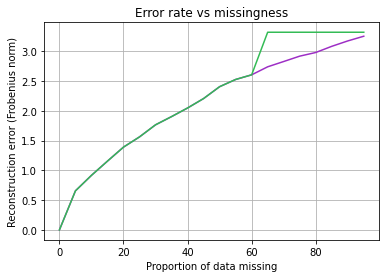

In [5]:
results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")
# TODO: Add legend
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

NNM seems to be pretty stable across parameters, but SVT results can change depending on $\tau$. SVT seems to converve with NNM results quite exactly when $\tau$ is really small or really large.

##### Here we hold the error rate at 40% and change $\tau$ for SVT

In [6]:
tau_lst = []

for tau in np.arange(0, 10, 1):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=40, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=tau)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    tau_lst.append([tau, svt_error])

<AxesSubplot:title={'center':'Error rate depending on tau'}, xlabel='tau'>

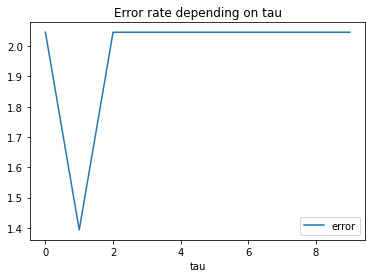

In [7]:
tau_df = pd.DataFrame(tau_lst, columns=["tau", "error"]).set_index("tau")
tau_df.plot(title="Error rate depending on tau")

SVT seems to want $\tau$ to be somewhere midway between 0 and the rank of the original matrix. Should test on other data.

### How do error rates vary by rank of the matrix?

In [8]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 1000,
              "max_iter_inner": 1000}


Here we vary rank for a synthetic dataset with 10% missing values

In [9]:
results_lst = []
n = 200
p = 10

for rank in range(p):

    # Produce r-rank data
    sim_norm = simulate_data.create_rank_r_matrix(rank, n, p)
    # Set to only 10% missing
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=10, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=5)
    svt_error = la.norm(sim_norm - sim_recovered_svt, ord='fro')
    
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(sim_norm - sim_recovered_nnm, ord='fro')
    
    results_lst.append([rank, svt_error, nnm_error])

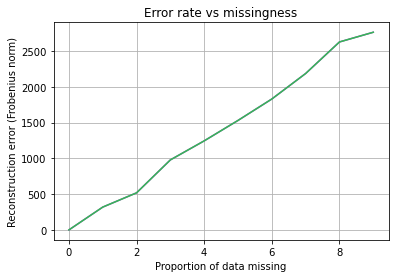

In [10]:
results_df = pd.DataFrame(results_lst, columns=["rank", "SVT", "NNM"]).set_index("rank")
# TODO: Add legend and update axes
errors.line_plot(results_df.index, results_df.SVT, results_df.NNM)

The reconstruction error increases fairly linearly with rank.

### How do error rates vary by the type of missingness?

In [11]:
# remove the last column
original_normalized_arr = sim_norm[:,:10]

In [12]:
def conditionally_remove_data(df, perc_missing):

    # make Income missing conditional on age
    sim_df = remove_data.missing_conditional_continuous(df, 
                                                     "Income", 
                                                     "Income", 
                                                     percent_missing=perc_missing)

    # make Age missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Age", 
                                                     "Age", 
                                                     percent_missing=perc_missing)

    # make NChild missing conditional on Continuous_EvenLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "NChild", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)


    # # make Continuous_LowLikelihood_0 missing conditional on Continuous_HighLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_LowLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_EvenLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_EvenLikelihood_0", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_HighLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_HighLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # conditionally remove entries from each discrete variable
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'InCensus', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_EvenLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_HighLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    
    return sim_df

In [13]:
# test the conditionally_remove_data function
original_normalized_df = pd.DataFrame(original_normalized_arr, columns=sim_df.columns[:10])
sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=30)

In [14]:
# confirm that Continuous_LowLikelihood_0 is missing for those with low values of Continuous_HighLikelihood_0
sim_conditional_missing[['Continuous_HighLikelihood_0', 'Continuous_LowLikelihood_0']].sort_values("Continuous_HighLikelihood_0")[:10]

,Continuous_HighLikelihood_0,Continuous_LowLikelihood_0
171,153.0,NaN
77,153.0,132.0
128,154.0,212.0
90,155.0,128.0
181,155.0,98.0
17,157.0,164.0
100,157.0,131.0
135,158.0,206.0
51,158.0,117.0
72,158.0,154.0


In [15]:
# check total missingness in conditional missing
conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
print(conditional_total_missingness)

# view missingness for features in conditional missing
sim_conditional_missing.isnull().mean()

0.308


Age                            0.300
Income                         0.300
NChild                         0.300
InCensus                       0.280
Discrete_LowLikelihood_0       0.460
Discrete_EvenLikelihood_0      0.275
Discrete_HighLikelihood_0      0.270
Continuous_LowLikelihood_0     0.295
Continuous_EvenLikelihood_0    0.300
Continuous_HighLikelihood_0    0.300
dtype: float64

In [16]:
# create randomly missing data matching the missingness of the conditional data
sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

In [17]:
# check total missingness in random missing
print(pd.DataFrame(sim_random_missing).isnull().sum().sum() / pd.DataFrame(sim_random_missing).size)

# view missingness for features in random missing
pd.DataFrame(sim_random_missing, columns=original_normalized_df.columns).isnull().mean()

0.308


Age                            0.325
Income                         0.265
NChild                         0.330
InCensus                       0.335
Discrete_LowLikelihood_0       0.280
Discrete_EvenLikelihood_0      0.305
Discrete_HighLikelihood_0      0.285
Continuous_LowLikelihood_0     0.285
Continuous_EvenLikelihood_0    0.335
Continuous_HighLikelihood_0    0.335
dtype: float64

In [22]:
results_lst = []

for missingness_pct in range(0, 100, 10):
    sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=missingness_pct)
    
    # check total missingness in conditional missing
    conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
    
    # create randomly missing data matching the missingness of the conditional data
    sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

    # random missing
    sim_recovered_random_svt = matrix_completion.svt(sim_random_missing, tau=5)
    random_svt_error = la.norm(np.round(original_normalized_arr, 4) - np.round(sim_recovered_random_svt, 4), ord='fro')

#     sim_recovered_random_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_random_missing)
#     random_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_random_nnm, 4), ord='fro')

    # conditional missing
    sim_recovered_conditional_svt = matrix_completion.svt(sim_conditional_missing, tau=5)
    conditional_svt_error = la.norm(np.round(original_normalized_arr, 4) - np.round(sim_recovered_conditional_svt, 4), ord='fro')

#     sim_recovered_conditional_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_conditional_missing)
#     conditional_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_conditional_nnm, 4), ord='fro')

    results_lst.append([conditional_total_missingness, random_svt_error, conditional_svt_error])

In [23]:
svt_errors = pd.DataFrame(results_lst, columns=['missingness','random','conditional']).set_index('missingness')

In [25]:
svt_errors

,random,conditional
missingness,,
0.0020,463.622691,160.654910
0.1090,2881.162265,2417.256710
0.2095,4046.454003,3413.098006
0.3010,4872.400435,4178.347760
0.3940,5555.803362,4850.212057
0.4795,6111.550622,5467.116425
0.5695,6678.366492,6091.704523
0.6445,7118.341942,6605.127251
0.7205,7524.108984,7149.054483


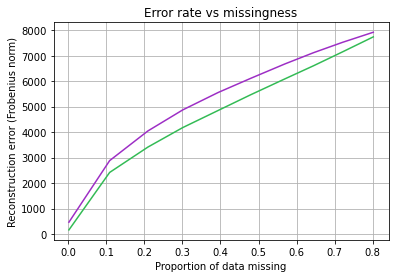

In [26]:
errors.line_plot(svt_errors.index, svt_errors.random, svt_errors.conditional)
# TODO: change axes labels
# TODO: add legend